# ANALYSING CIC 2017 DATASET AND SELECTING BEST FEATURES FOR HULK ATTACK


## Index
    1. Data Preparation
    2. Data Split
    3. Feature Selection
    4. PCA

In [1]:
import os
import subprocess
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from __future__ import print_function
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def get_data():
    if os.path.exists("hulk_filtered.csv"):
        print("-- hulk.csv found locally")
    df = pd.read_csv("hulk_filtered.csv", index_col=False)
    return df

In [3]:
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)
    return (df_mod, targets)

In [4]:
data = get_data()

-- hulk.csv found locally


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# 1.0 Data processing

### We initially drop variables that won't contribute to knowlege of hulk attack because they change from instance to instance

In [5]:
columns = ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',]
data.drop(columns, inplace=True, axis=1)
print(data.keys())
print(data.shape[0])
print(data.shape[1])

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SY

### We also need to convert lables into numeric values for classification

In [6]:
df2, targets = encode_target(data, " Label")



### We drop any rows that contain NaN

In [7]:
df2 = df2.dropna(axis=0, how='any')
df2.isnull().sum().sum()

0

### We also drop columns that have 0 variance

In [8]:
list_unq = (df2.apply(pd.Series.nunique) != 1)
list_unq[list_unq == 0]

 Bwd PSH Flags           False
 Fwd URG Flags           False
 Bwd URG Flags           False
 CWE Flag Count          False
Fwd Avg Bytes/Bulk       False
 Fwd Avg Packets/Bulk    False
 Fwd Avg Bulk Rate       False
 Bwd Avg Bytes/Bulk      False
 Bwd Avg Packets/Bulk    False
Bwd Avg Bulk Rate        False
dtype: bool

In [9]:
df2 = df2.loc[:, df2.apply(pd.Series.nunique) != 1]

# 2.0 Data split
## We split data in features, lables

In [10]:
features = list(df2.columns[:-2])
y = df2["Target"]
X = df2[features]

In [11]:
X

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,4,2,0,31,0.0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,318,4,0,64,0.0,46,6,16.000000,20.000000,0,...,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,0,31,0.0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55718,1,2,0,0.0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,0,31,0.0,31,0,15.500000,21.920310,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,48,2,0,12,0.0,6,6,6.000000,0.000000,0,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,189,2,1,12,6.0,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,167,2,1,12,6.0,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,164,2,1,12,6.0,6,6,6.000000,0.000000,6,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,227,2,1,0,0.0,0,0,0.000000,0.000000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1    229777
0     21839
Name: Target, dtype: int64

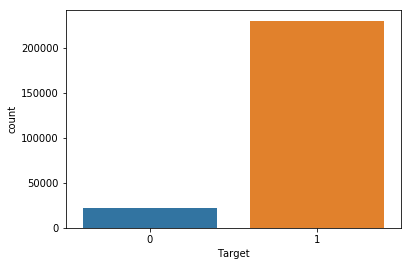

In [12]:
graph = sns.countplot(y ,label="Count")
df2["Target"].value_counts()

### Heat map

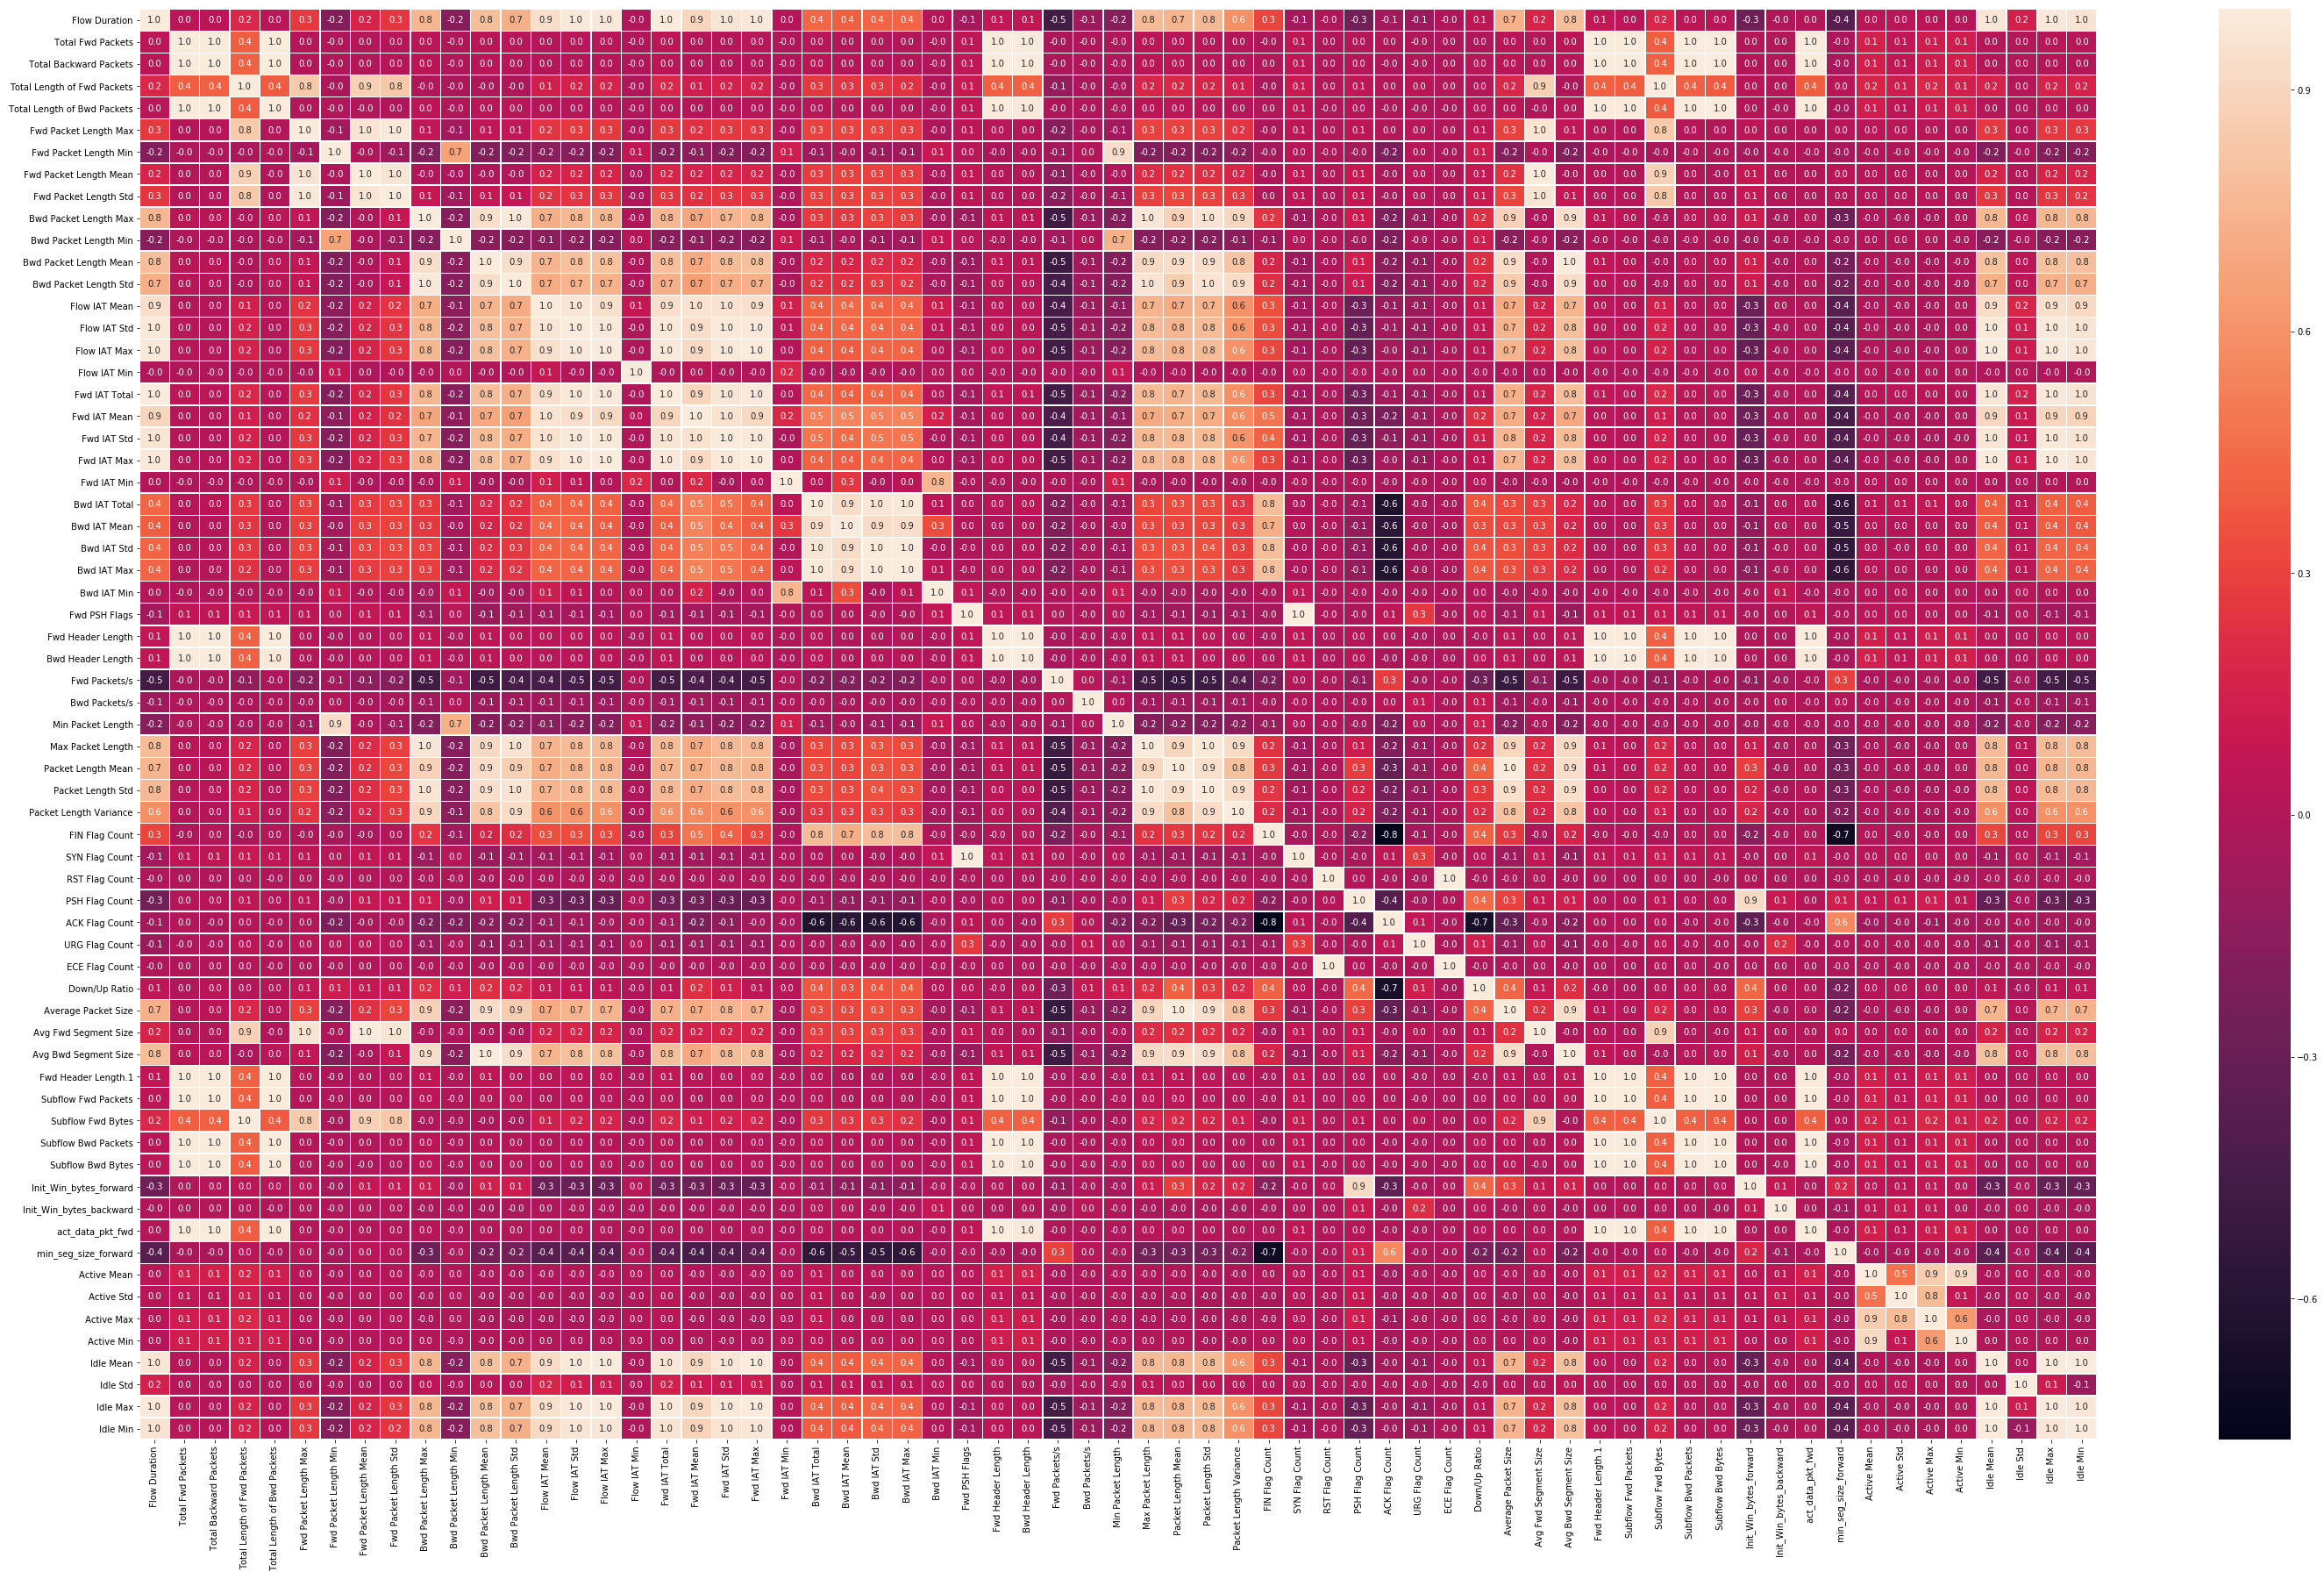

In [13]:
f, ax = plt.subplots(figsize=(50, 30))
sns_plot = sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

In [14]:
sns_plot.figure.savefig("output_50_30_hulk.png")

### df2 is original data frame with neccesary processing done. From now on we make variants of data frame X and Y








# 3.0 Feature Selection


### Index
     3.1 1 Correlation
     3.2 K best features
     3.3 Recursive feature elimination with random forest
     3.4 Recursice feature elimination with cross validation and random forest
     3.5 Tree based feature selection

## 3.1 High Correlation



In [15]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [16]:
upper

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Flow Duration,NaN,0.046348,0.038104,0.186794,0.034034,0.266859,0.184710,0.170990,0.253268,0.753385,...,0.022042,0.363498,0.024861,0.033670,0.040361,0.015310,0.978706,0.152337,0.988062,0.958755
Total Fwd Packets,NaN,NaN,0.995308,0.400343,0.998640,0.014823,0.009507,0.005461,0.008879,0.039366,...,0.998153,0.018293,0.147719,0.064953,0.127207,0.139862,0.026629,0.004823,0.026954,0.025951
Total Backward Packets,NaN,NaN,NaN,0.403946,0.993176,0.013734,0.005850,0.005684,0.008836,0.036512,...,0.994092,0.022034,0.146221,0.057727,0.121854,0.142534,0.019184,0.001675,0.019227,0.018869
Total Length of Fwd Packets,NaN,NaN,NaN,NaN,0.386635,0.845877,0.032234,0.872545,0.834130,0.006201,...,0.398363,0.030442,0.173836,0.126007,0.183901,0.147937,0.166428,0.012600,0.166702,0.164277
Total Length of Bwd Packets,NaN,NaN,NaN,NaN,NaN,0.005392,0.007175,0.002020,0.001260,0.038248,...,0.997745,0.017244,0.137456,0.051426,0.110756,0.134564,0.018070,0.001394,0.018088,0.017813
Fwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,0.054898,0.963070,0.992327,0.070466,...,0.011289,0.016948,0.023157,0.026926,0.032242,0.017082,0.261854,0.015601,0.261775,0.259077
Fwd Packet Length Min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004285,0.069593,0.187498,...,0.001846,0.043859,0.003720,0.006036,0.006440,0.001954,0.183521,0.015634,0.183943,0.181119
Fwd Packet Length Mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.968310,0.005408,...,0.005901,0.041920,0.014643,0.017878,0.018407,0.009666,0.171019,0.006482,0.170611,0.169609
Fwd Packet Length Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080956,...,0.006508,0.016916,0.016943,0.020966,0.022660,0.011607,0.251993,0.012220,0.251644,0.249634
Bwd Packet Length Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019976,0.273575,0.006597,0.023884,0.018827,0.002496,0.762260,0.048791,0.762283,0.754057


In [17]:
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]
print(len(to_drop))
print(to_drop)

8
[' SYN Flag Count', ' ECE Flag Count', ' Avg Fwd Segment Size', ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', ' Subflow Bwd Packets']


### 3.1.2 To get an idea who all were correalted perfectly i.e 1.0

In [18]:
corrMatrix = X.corr()
corrMatrix.loc[:,:] =  np.tril(corr_matrix, k=-1)

already_in = set()
result_1 = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] == 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result_1.append(perfect_corr)

In [19]:
for element in result_1:
    print(element)

['Subflow Fwd Packets', ' Total Fwd Packets']
[' Subflow Bwd Packets', ' Total Backward Packets']
[' Subflow Fwd Bytes', 'Total Length of Fwd Packets']
[' Avg Fwd Segment Size', ' Fwd Packet Length Mean']
[' Avg Bwd Segment Size', ' Bwd Packet Length Mean']
[' SYN Flag Count', 'Fwd PSH Flags']
[' Fwd Header Length.1', ' Fwd Header Length']
[' ECE Flag Count', ' RST Flag Count']


### 3.1.4 Dropping features with 1 correlation

In [20]:
X_new = X.drop(X[to_drop], axis=1)

In [21]:
X_new.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,4,2,0,31,0.0,31,0,15.5,21.92031,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,318,4,0,64,0.0,46,6,16.0,20.00000,0,...,3,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,0,31,0.0,31,0,15.5,21.92031,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55718,1,2,0,0.0,0,0,0.0,0.00000,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,0,31,0.0,31,0,15.5,21.92031,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_new.isnull().sum().sum()

0

In [23]:
def fix_data_frame(x_train):
    col = x_train.columns[x_train.dtypes.eq(object)]
    x_train[col] = x_train[col].apply(pd.to_numeric, errors='coerce', axis=1)
    return np.nan_to_num(x_train)

In [24]:
def generate_data(x, y, split, seed):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=seed)
    x_train = fix_data_frame(x_train)
    x_test = fix_data_frame(x_test)
    return x_train, x_test, y_train, y_test

In [25]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

## 3.2 K-best

In [26]:
x_train, x_test, y_train, y_test = generate_data(X_new, y, 0, 42)
ranks = {}
y_train.value_counts()

1    229777
0     21839
Name: Target, dtype: int64

In [27]:
select_feature_5 = SelectKBest(f_classif, k=5).fit(x_train, y_train.values)

In [28]:
print("Using f_classif with Kbest returns : \n")

print("5 Features : ", X_new.columns[select_feature_5.get_support(indices=True)])
print('\n')

Using f_classif with Kbest returns : 

5 Features :  Index(['Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Bwd Packet Length Min',
       ' Min Packet Length'],
      dtype='object')




#### Data feature ranking on ANOVA F-based at 30% training data

In [29]:
scores = select_feature_5.scores_
scores  = [float(i) for i in scores]
features = X_new.columns
    
k_best_f_classif = zip(scores, features)

k_best_f_classif = list(k_best_f_classif)

k_best_f_classif.sort(key= lambda x : x[0], reverse=True)
for element in k_best_f_classif:
    print(element[1].lstrip())

ranks["K-Best"] = ranking(scores, X_new.columns);

Min Packet Length
Bwd Packet Length Min
Fwd Packet Length Min
Fwd Packet Length Mean
Total Length of Fwd Packets
Bwd Packet Length Mean
Fwd Packet Length Max
Bwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Std
URG Flag Count
Packet Length Std
Fwd IAT Std
Idle Max
Idle Mean
Packet Length Mean
Fwd IAT Max
Flow IAT Max
Fwd PSH Flags
Idle Min
Max Packet Length
Average Packet Size
Flow IAT Std
Packet Length Variance
Flow IAT Mean
Fwd IAT Total
Fwd IAT Mean
Flow Duration
Init_Win_bytes_backward
FIN Flag Count
Down/Up Ratio
Active Max
Bwd Packets/s
PSH Flag Count
ACK Flag Count
Active Std
Active Mean
Fwd IAT Min
Init_Win_bytes_forward
Fwd Packets/s
Bwd IAT Min
Flow Packets/s
Active Min
Flow Bytes/s
Bwd IAT Mean
Bwd IAT Total
act_data_pkt_fwd
Total Backward Packets
Flow IAT Min
Total Fwd Packets
Bwd Header Length
min_seg_size_forward
Idle Std
Fwd Header Length
Total Length of Bwd Packets
Subflow Bwd Bytes
RST Flag Count
Bwd IAT Max
Bwd IAT Std


## 3.3 Recursive Feature Elimination using Random Forest

In [30]:
random_forest = RandomForestClassifier()      
rfe = RFE(estimator=random_forest, n_features_to_select=10, step=1)

In [31]:
rfe = rfe.fit(x_train, y_train.values)

In [32]:
print(rfe.support_)
print(len(rfe.support_))

[False  True False False False  True False  True False False  True False
 False  True False False False False False False False False False False
 False False False False False False  True False False False  True False
 False False False False False False False False False False False  True
  True False False False False  True False False False False False]
59


In [33]:
print('Chosen best 10 feature by rfe:', X_new.columns[rfe.support_])

rfe_features_correlated_10 = X_new.columns[rfe.support_]

Chosen best 10 feature by rfe: Index([' Total Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Mean', ' Bwd Packet Length Min', 'Flow Bytes/s',
       ' Fwd Header Length', ' Min Packet Length', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' Active Max'],
      dtype='object')


In [34]:
scores = rfe.ranking_
scores  = [i for i in scores]
features = X_new.columns
    
rfe_rankings = zip(scores, features)

rfe_rankings = list(rfe_rankings)

rfe_rankings.sort(key= lambda x : x[0])
for element in rfe_rankings:
    print(element)

(1, ' Total Fwd Packets')
(1, ' Fwd Packet Length Max')
(1, ' Fwd Packet Length Mean')
(1, ' Bwd Packet Length Min')
(1, 'Flow Bytes/s')
(1, ' Fwd Header Length')
(1, ' Min Packet Length')
(1, 'Init_Win_bytes_forward')
(1, ' Init_Win_bytes_backward')
(1, ' Active Max')
(2, ' Total Length of Bwd Packets')
(3, ' Fwd IAT Max')
(4, ' Fwd IAT Min')
(5, ' act_data_pkt_fwd')
(6, ' Packet Length Mean')
(7, 'FIN Flag Count')
(8, ' Fwd Packet Length Std')
(9, ' Bwd Packets/s')
(10, ' Packet Length Variance')
(11, ' Average Packet Size')
(12, ' Total Backward Packets')
(13, ' Flow IAT Min')
(14, ' Fwd IAT Mean')
(15, 'Bwd Packet Length Max')
(16, 'Fwd IAT Total')
(17, ' Fwd IAT Std')
(18, ' Flow Duration')
(19, ' Bwd Packet Length Std')
(20, ' PSH Flag Count')
(21, ' Bwd Packet Length Mean')
(22, 'Fwd PSH Flags')
(23, 'Total Length of Fwd Packets')
(24, ' Flow IAT Max')
(25, ' ACK Flag Count')
(26, 'Fwd Packets/s')
(27, ' Flow IAT Mean')
(28, ' Packet Length Std')
(29, ' Flow IAT Std')
(30, ' Flo

In [35]:
random_forest = RandomForestClassifier() 
rfe = RFE(estimator=random_forest, n_features_to_select=1)
rfe.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [36]:
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), X_new.columns, order=-1)

In [37]:
ranks

{'K-Best': {' ACK Flag Count': 0.05,
  ' Active Max': 0.06,
  ' Active Min': 0.01,
  ' Active Std': 0.04,
  ' Average Packet Size': 0.16,
  ' Bwd Header Length': 0.0,
  ' Bwd IAT Max': 0.0,
  ' Bwd IAT Mean': 0.0,
  ' Bwd IAT Min': 0.02,
  ' Bwd IAT Std': 0.0,
  ' Bwd Packet Length Mean': 0.37,
  ' Bwd Packet Length Min': 0.88,
  ' Bwd Packet Length Std': 0.32,
  ' Bwd Packets/s': 0.06,
  ' Down/Up Ratio': 0.07,
  ' Flow Duration': 0.12,
  ' Flow IAT Max': 0.17,
  ' Flow IAT Mean': 0.12,
  ' Flow IAT Min': 0.0,
  ' Flow IAT Std': 0.16,
  ' Flow Packets/s': 0.02,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.17,
  ' Fwd IAT Mean': 0.12,
  ' Fwd IAT Min': 0.02,
  ' Fwd IAT Std': 0.17,
  ' Fwd Packet Length Max': 0.37,
  ' Fwd Packet Length Mean': 0.48,
  ' Fwd Packet Length Min': 0.78,
  ' Fwd Packet Length Std': 0.32,
  ' Idle Max': 0.17,
  ' Idle Min': 0.17,
  ' Idle Std': 0.0,
  ' Init_Win_bytes_backward': 0.08,
  ' Max Packet Length': 0.17,
  ' Min Packet Length': 1.0,
  ' PSH Fla

## 3.5 Recursive Feature Elimination with Corss Validation

In [38]:
clf_rf = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf, step=1, cv=10, scoring='accuracy')   #10-fold cross-validation
rfecv = rfecv.fit(x_train, y_train.values)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_new.columns[rfecv.support_])

Optimal number of features : 9
Best features : Index([' Total Backward Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Std', ' Bwd Packet Length Min', ' Fwd IAT Mean',
       ' Fwd IAT Max', ' Min Packet Length', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward'],
      dtype='object')


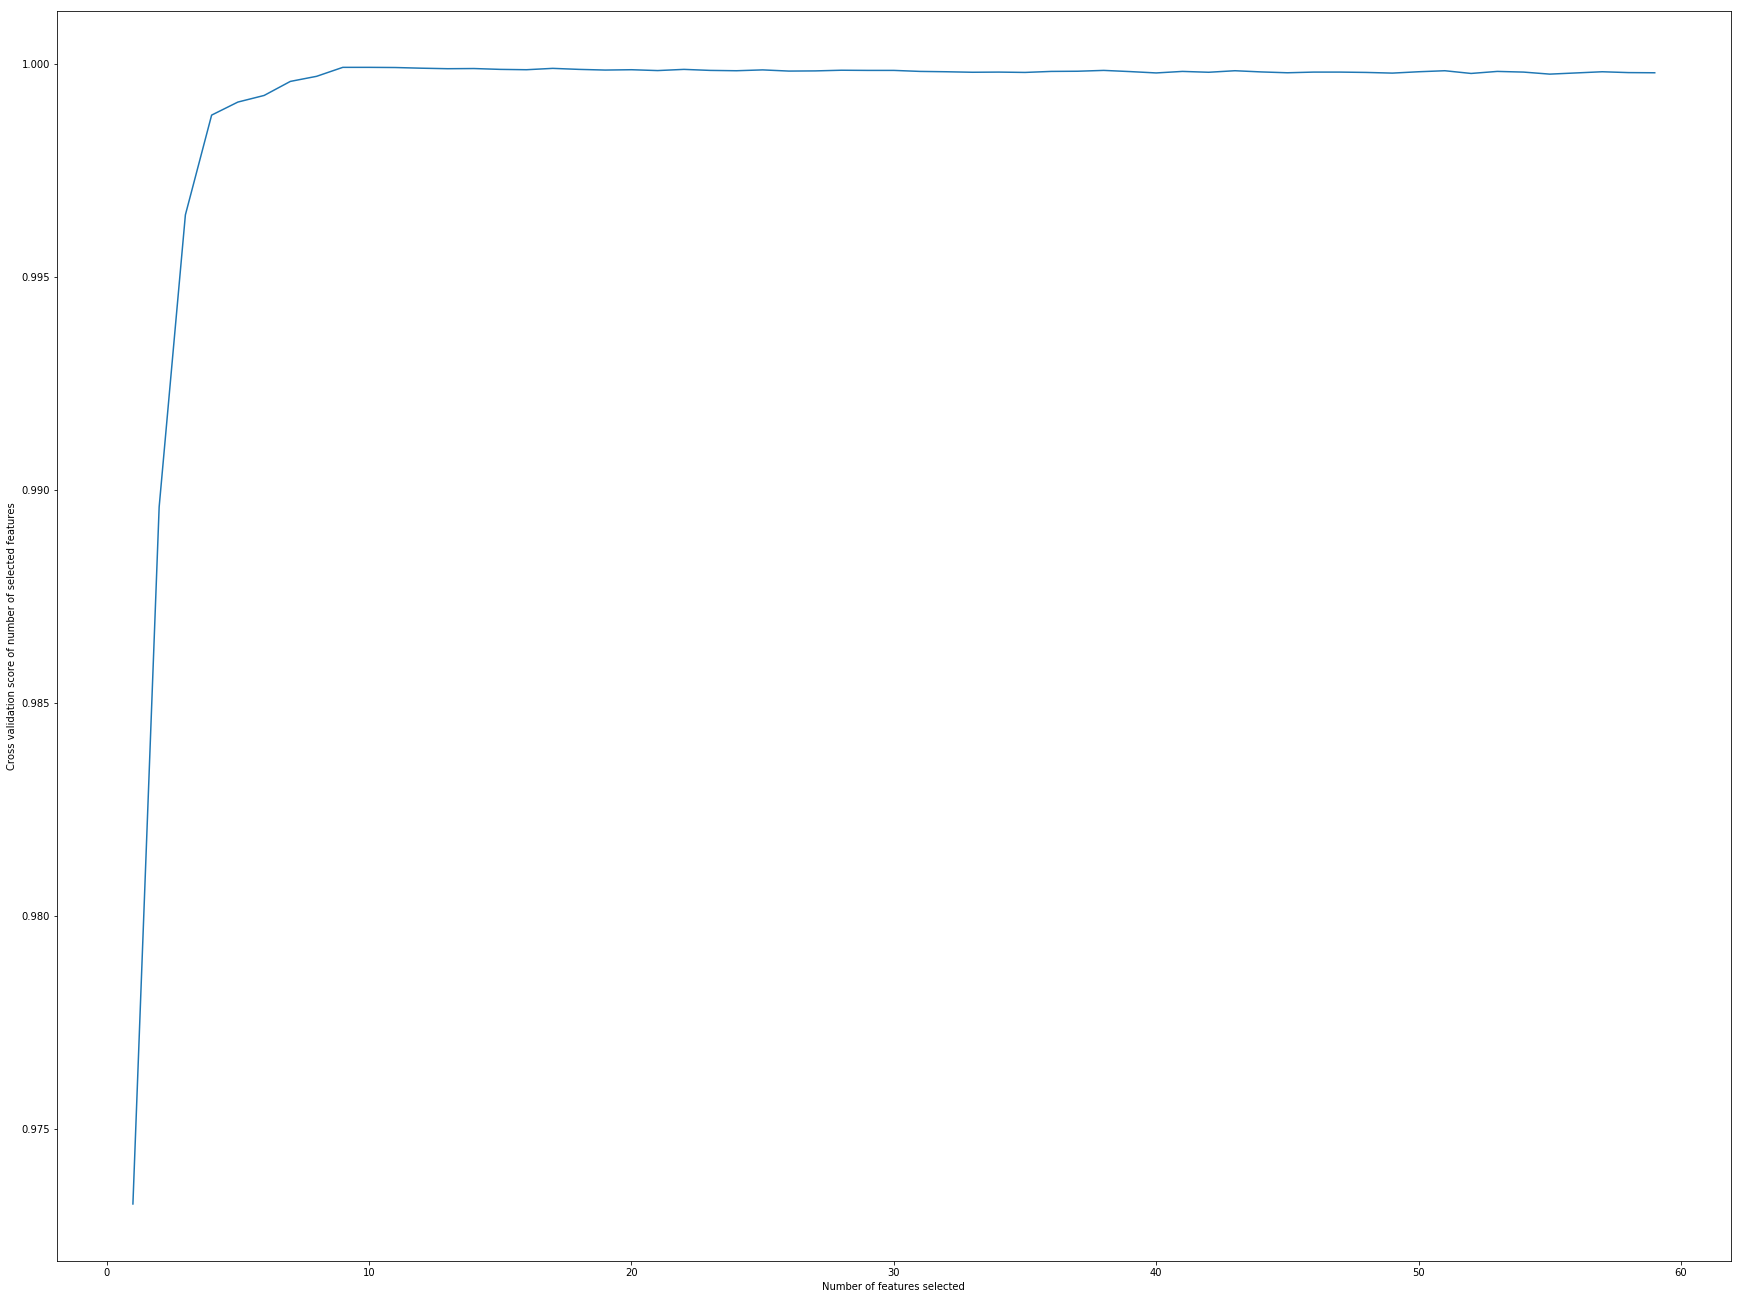

In [39]:
plt.figure(1, figsize=(30, 23))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig("REFCV_hulk_100.png")

In [40]:
for element in range(len(rfecv.grid_scores_)):
    print(element + 1, rfecv.grid_scores_[element])
    

1 0.9732368523907005
2 0.9895952433345206
3 0.9964508555328591
4 0.9987918003583548
5 0.9990978216328535
6 0.999252828160355
7 0.9995826953899927
8 0.9997019278509598
9 0.9999125656209067
10 0.9999125646731656
11 0.9999085905842507
12 0.9998926934387773
13 0.999880770224266
14 0.9998847444711462
15 0.9998648730787799
16 0.999856924111149
17 0.9998887185600613
18 0.9998648727628622
19 0.9998489757753412
20 0.9998569237952312
21 0.9998370525608425
22 0.999864872289004
23 0.9998410268077228
24 0.9998330781559972
25 0.9998529498642814
26 0.9998251285565555
27 0.9998291039091294
28 0.9998450004227799
29 0.9998410266497701
30 0.9998410263338646
31 0.9998171814843941
32 0.9998092326747283
33 0.9997973097761351
34 0.9998012840230153
35 0.9997933348974316
36 0.9998171811685014
37 0.9998211549414986
38 0.9998410271236281
39 0.9998132067636559
40 0.9997814123147561
41 0.9998171808525711
42 0.9997973094602172
43 0.9998330775241613
44 0.9998052577960124
45 0.9997853860877534
46 0.9998012833911669
4

In [41]:
print(rfecv.grid_scores_[-52]) #8
print(rfecv.grid_scores_[-35]) #25
print(rfecv.grid_scores_[-46]) #14
print(X_new.shape)

print(rfecv.grid_scores_[-32]) #28
print(rfecv.grid_scores_[-45]) #15


0.9997019278509598
0.9998529498642814
0.9998847444711462
(251616, 59)
0.9998450004227799
0.9998648730787799


### Tree based feature selecion

In [42]:
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(x_train, y_train.values)
importances = clr_rf.feature_importances_

In [43]:
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

ranking_tree_based = []
for f in range(x_train.shape[1]):
    print(f + 1, features[indices[f]])
    ranking_tree_based.append(features[indices[f]])

ranking_tree_zip = zip(features[indices], importances[indices])

ranking_tree_zip = list(ranking_tree_zip)

ranking_tree_zip.sort(key= lambda x : x[1], reverse=True)

for element in ranking_tree_zip:
    print(element[1])
    
ranks["RF"] = ranking(clf_rf.feature_importances_, X_new.columns)

Feature ranking:
1  Bwd Packet Length Min
2  Min Packet Length
3  Fwd Packet Length Std
4  Fwd IAT Mean
5 Init_Win_bytes_forward
6 Total Length of Fwd Packets
7 Active Mean
8  Fwd IAT Max
9 Fwd IAT Total
10 Flow Bytes/s
11  Fwd Packet Length Max
12  Fwd Packet Length Mean
13  Packet Length Std
14  act_data_pkt_fwd
15  Packet Length Variance
16  Active Min
17  Active Max
18  Packet Length Mean
19  Fwd IAT Min
20  Bwd Packet Length Std
21  Subflow Bwd Bytes
22  Average Packet Size
23  URG Flag Count
24  Bwd Packet Length Mean
25  Init_Win_bytes_backward
26 FIN Flag Count
27  Total Length of Bwd Packets
28 Bwd Packet Length Max
29  Total Backward Packets
30  Fwd Header Length
31  Flow IAT Mean
32  Bwd Packets/s
33 Fwd PSH Flags
34 Idle Mean
35  Idle Max
36  PSH Flag Count
37  Flow Duration
38  Total Fwd Packets
39  Flow IAT Min
40  min_seg_size_forward
41  ACK Flag Count
42  Flow Packets/s
43  Flow IAT Max
44  Max Packet Length
45  Bwd Header Length
46  Idle Min
47  Flow IAT Std
48  Bwd I

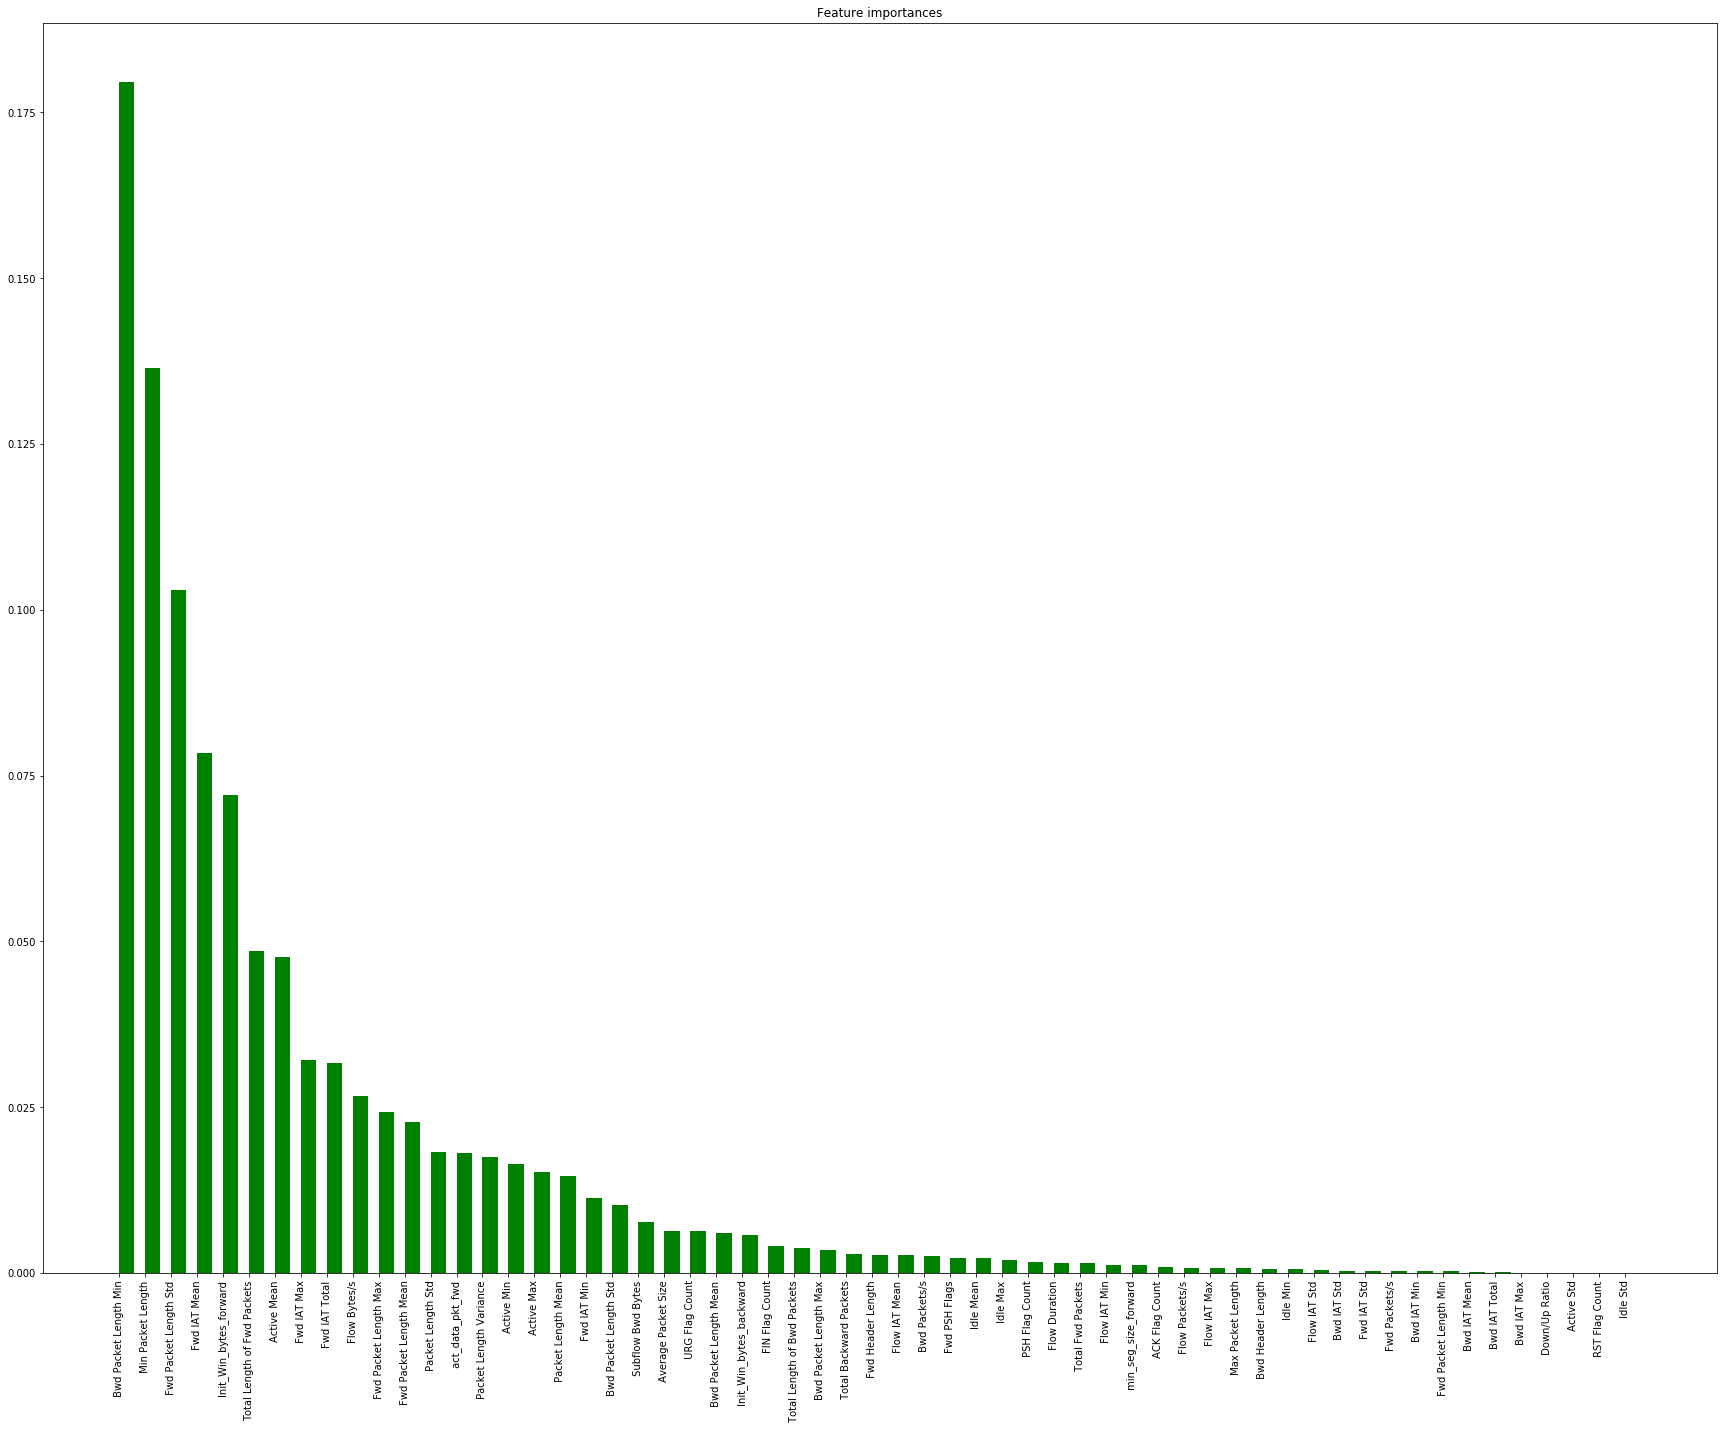

In [44]:
plt.figure(1, figsize=(30, 23))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], 0.6,
       color="g", align="edge")
plt.xticks(range(x_train.shape[1]), X_new.columns[indices],rotation=90)
plt.savefig("rf_features_hulk_100.png")

## PCA

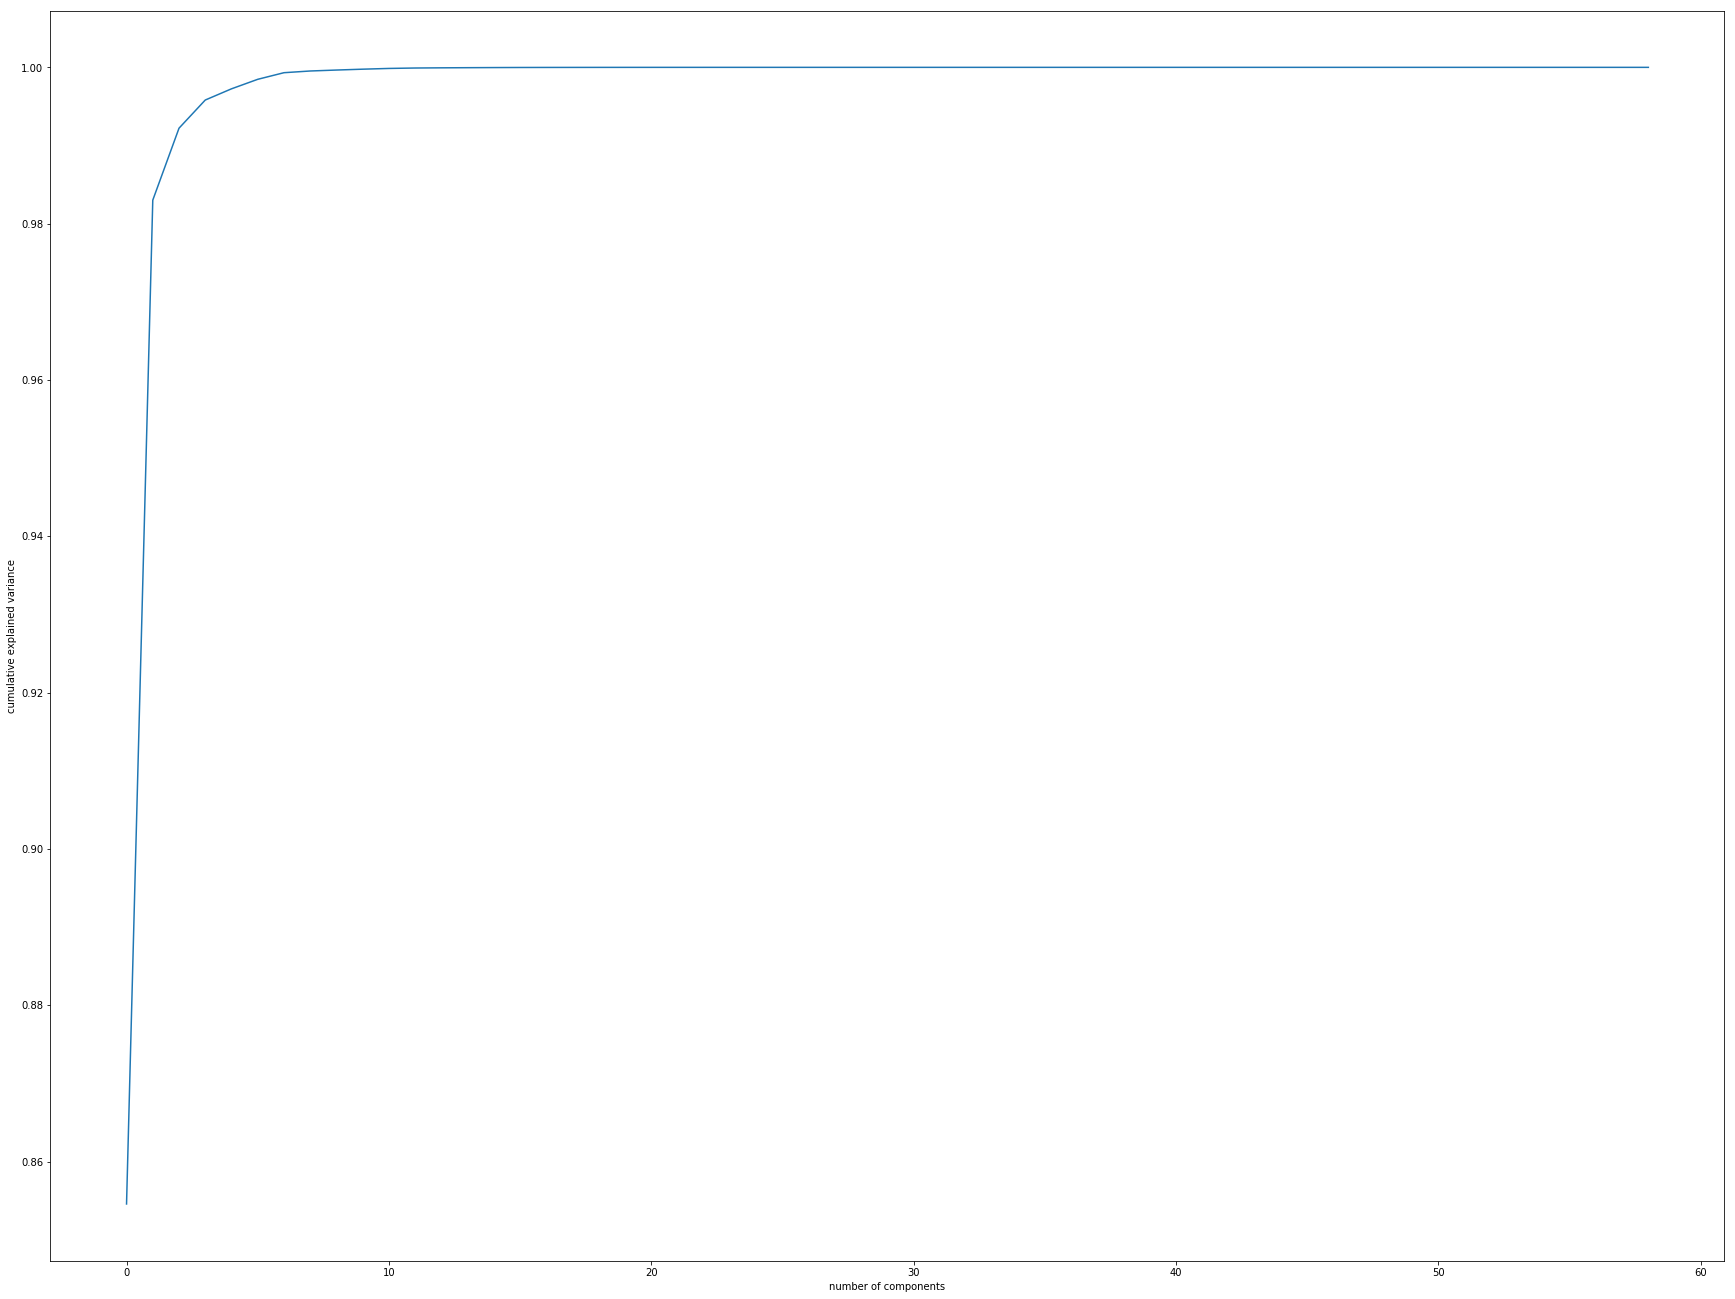

In [45]:
x_train_N = (x_train - x_train.mean())/(x_train.max() - x_train.min())
#x_test_N = (x_test - x_test.mean())/(x_test.max() - x_test.min())

pca = PCA().fit(x_train_N)
plt.figure(1, figsize=(30, 23))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.savefig("pca_cumulative_hulk_100.png")

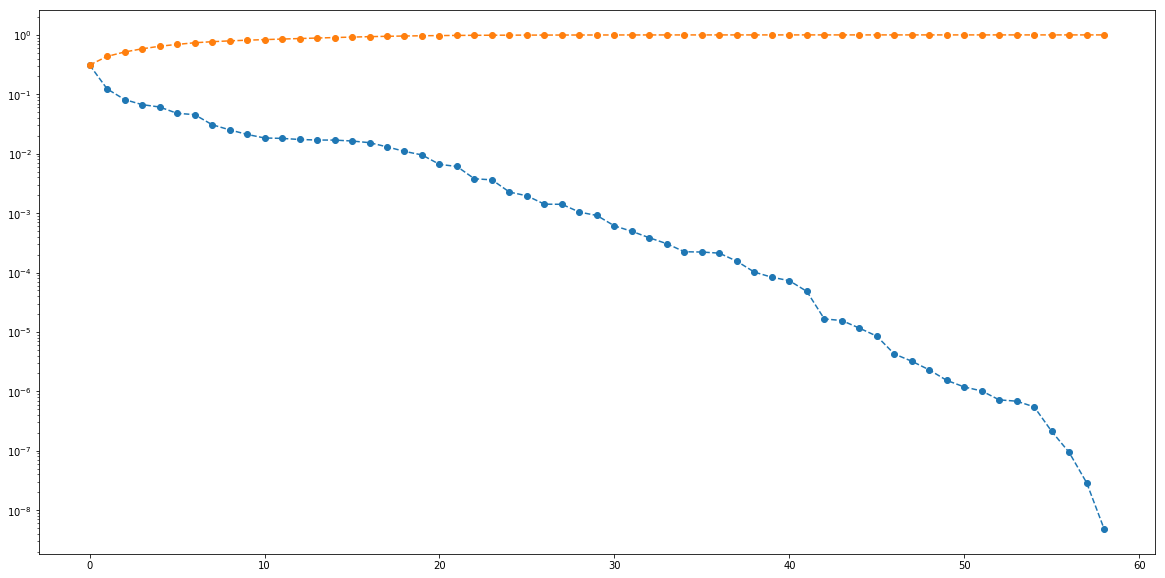

In [46]:
z_scaler = StandardScaler()

z_data = z_scaler.fit_transform(x_train)
pca_trafo = PCA().fit(z_data);

plt.figure(figsize=(20,10))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o');
plt.savefig("pca_cumulative_individual_100_hulk.png")

In [47]:
variance = [0.999, 0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.85, 0.80]
print("Original shape:   ", x_train.shape)

for i in variance:
    pca_var = PCA(i)
    pca_var.fit(x_train)
    x_var = pca_var.transform(x_train_N)
    print("Transformed shape for variance " + str(i) + " is ", x_var.shape)
    

Original shape:    (251616, 59)
Transformed shape for variance 0.999 is  (251616, 7)
Transformed shape for variance 0.99 is  (251616, 3)
Transformed shape for variance 0.98 is  (251616, 2)
Transformed shape for variance 0.97 is  (251616, 2)
Transformed shape for variance 0.96 is  (251616, 2)
Transformed shape for variance 0.95 is  (251616, 2)
Transformed shape for variance 0.9 is  (251616, 2)
Transformed shape for variance 0.85 is  (251616, 1)
Transformed shape for variance 0.8 is  (251616, 1)


## Summary

### 1. Eliminate features with 0 variance
### 2. Eliminate features with 1 correlation
### 3. Estimate feature rankings (various data set sizes) with
        K best
        Recursive feature elimination
        Recursive feature elimination with cross validation
        Random Forest
### 4. Apply PCA just to check how variance is distributed
### 5. Make a classifier with PCA and check accuracy, this will be ML solution for hulk
### 6. Find minimal set of features for rule generation with highest accuracy
### 7. Generate rules

## Obtained Feature rankings

### 1.0 100% Split

In [48]:
print("RFECV at 100% train:")
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_new.columns[rfecv.support_])

RFECV at 100% train:
Optimal number of features : 9
Best features : Index([' Total Backward Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Std', ' Bwd Packet Length Min', ' Fwd IAT Mean',
       ' Fwd IAT Max', ' Min Packet Length', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward'],
      dtype='object')


In [49]:
#rfecv.score(x_test, y_test)

In [50]:
ranks

{'K-Best': {' ACK Flag Count': 0.05,
  ' Active Max': 0.06,
  ' Active Min': 0.01,
  ' Active Std': 0.04,
  ' Average Packet Size': 0.16,
  ' Bwd Header Length': 0.0,
  ' Bwd IAT Max': 0.0,
  ' Bwd IAT Mean': 0.0,
  ' Bwd IAT Min': 0.02,
  ' Bwd IAT Std': 0.0,
  ' Bwd Packet Length Mean': 0.37,
  ' Bwd Packet Length Min': 0.88,
  ' Bwd Packet Length Std': 0.32,
  ' Bwd Packets/s': 0.06,
  ' Down/Up Ratio': 0.07,
  ' Flow Duration': 0.12,
  ' Flow IAT Max': 0.17,
  ' Flow IAT Mean': 0.12,
  ' Flow IAT Min': 0.0,
  ' Flow IAT Std': 0.16,
  ' Flow Packets/s': 0.02,
  ' Fwd Header Length': 0.0,
  ' Fwd IAT Max': 0.17,
  ' Fwd IAT Mean': 0.12,
  ' Fwd IAT Min': 0.02,
  ' Fwd IAT Std': 0.17,
  ' Fwd Packet Length Max': 0.37,
  ' Fwd Packet Length Mean': 0.48,
  ' Fwd Packet Length Min': 0.78,
  ' Fwd Packet Length Std': 0.32,
  ' Idle Max': 0.17,
  ' Idle Min': 0.17,
  ' Idle Std': 0.0,
  ' Init_Win_bytes_backward': 0.08,
  ' Max Packet Length': 0.17,
  ' Min Packet Length': 1.0,
  ' PSH Fla

In [51]:
r = {}
for name in X_new.columns:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t\t\t\t%s" % "\t".join(methods))
for name in X_new.columns:
    print("%s\t\t\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))


				K-Best	RF	RFE	Mean
 Flow Duration			0.12	0.01	0.59	0.24
 Total Fwd Packets			0.0	0.01	0.9	0.3
 Total Backward Packets			0.0	0.02	0.83	0.28
Total Length of Fwd Packets			0.43	0.27	0.67	0.46
 Total Length of Bwd Packets			0.0	0.02	0.36	0.13
 Fwd Packet Length Max			0.37	0.14	1.0	0.5
 Fwd Packet Length Min			0.78	0.0	0.47	0.42
 Fwd Packet Length Mean			0.48	0.13	0.52	0.38
 Fwd Packet Length Std			0.32	0.57	0.91	0.6
Bwd Packet Length Max			0.32	0.02	0.31	0.22
 Bwd Packet Length Min			0.88	1.0	0.95	0.94
 Bwd Packet Length Mean			0.37	0.03	0.55	0.32
 Bwd Packet Length Std			0.32	0.06	0.34	0.24
Flow Bytes/s			0.01	0.15	0.41	0.19
 Flow Packets/s			0.02	0.0	0.57	0.2
 Flow IAT Mean			0.12	0.02	0.43	0.19
 Flow IAT Std			0.16	0.0	0.24	0.13
 Flow IAT Max			0.17	0.0	0.62	0.26
 Flow IAT Min			0.0	0.01	0.71	0.24
Fwd IAT Total			0.12	0.18	0.69	0.33
 Fwd IAT Mean			0.12	0.44	0.72	0.43
 Fwd IAT Std			0.17	0.0	0.38	0.18
 Fwd IAT Max			0.17	0.18	0.88	0.41
 Fwd IAT Min			0.02	0.06	0.81	0.3
Bwd IAT Total

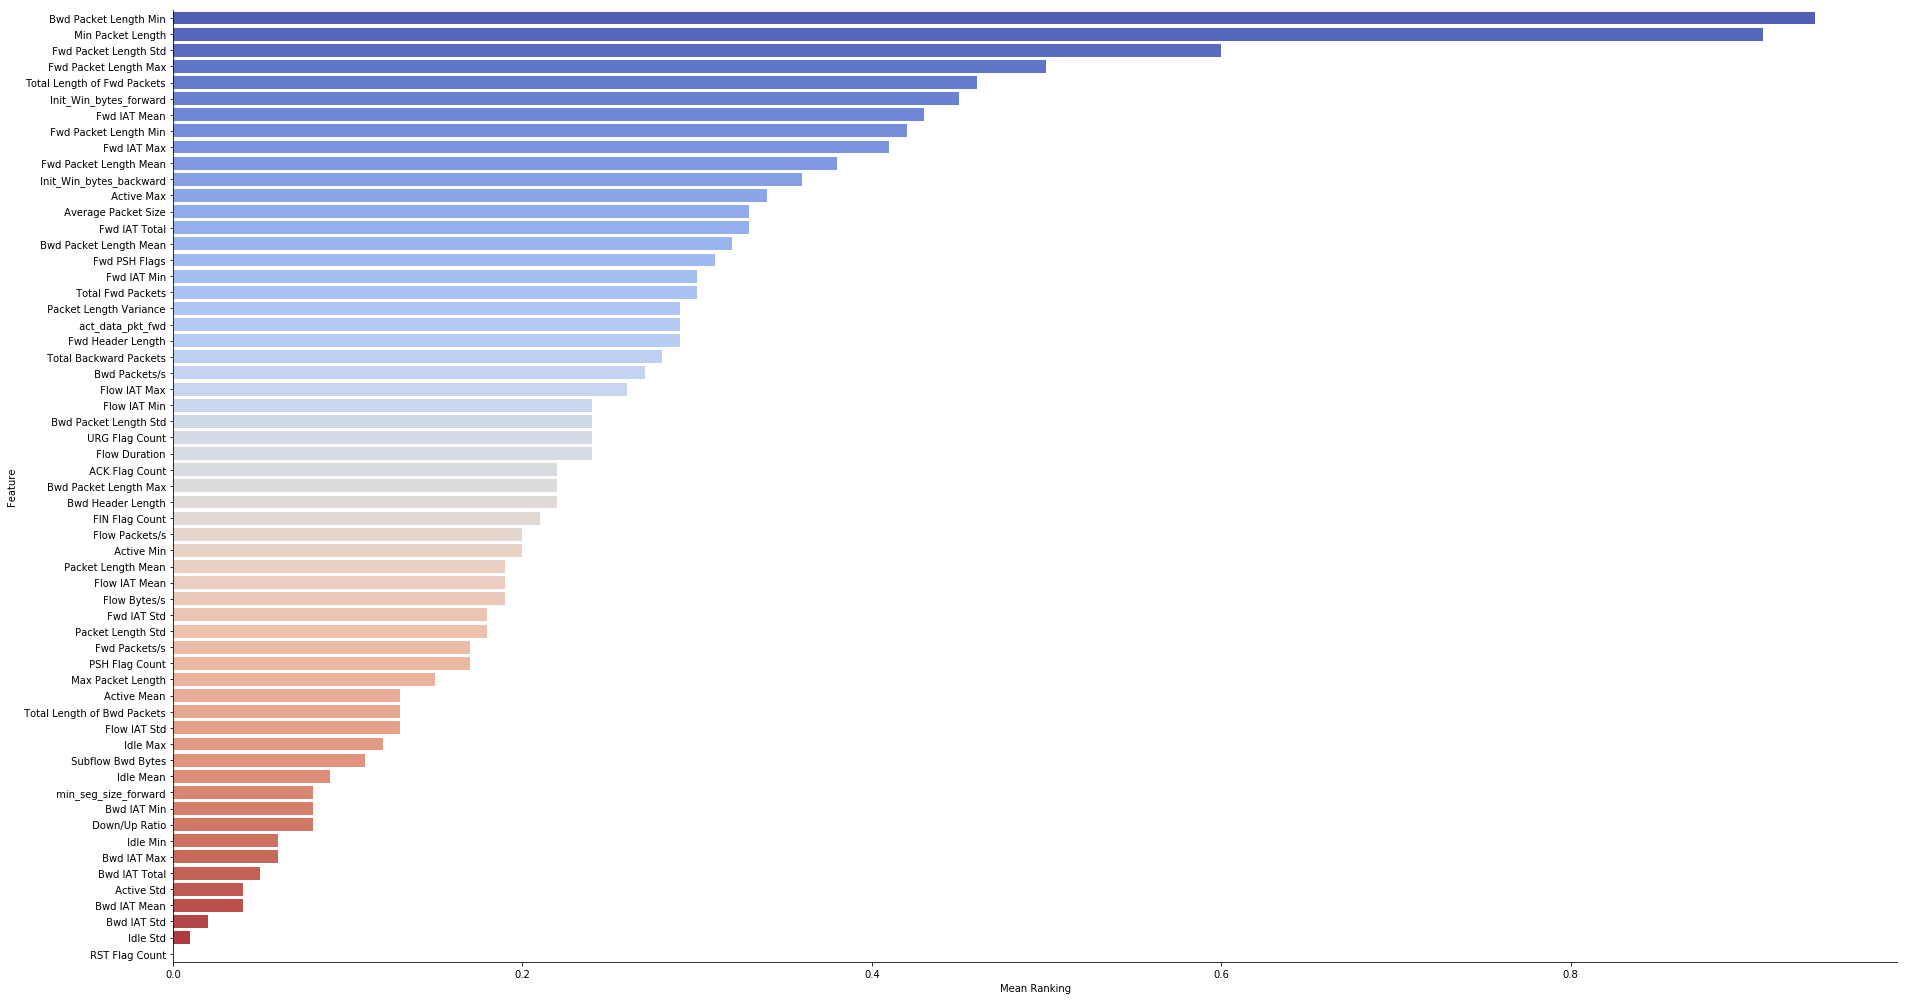

In [52]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
y2k = sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')
y2k.savefig("mean_ranking_100_hulk.png")

In [53]:
meanplot

,Feature,Mean Ranking
44,Bwd Packet Length Min,0.94
54,Min Packet Length,0.91
8,Fwd Packet Length Std,0.60
19,Fwd Packet Length Max,0.50
37,Total Length of Fwd Packets,0.46
47,Init_Win_bytes_forward,0.45
2,Fwd IAT Mean,0.43
39,Fwd Packet Length Min,0.42
53,Fwd IAT Max,0.41
49,Fwd Packet Length Mean,0.38


## Testing

### Three highest grid scores were obtained at 8, 14 and 25 features. So we use these

In [54]:
#YOU CAN GENERATE DIFFERENT TRAINING SAMPLES HERE at #here. x_train, y_train is 70% by default. 

### RFE

In [55]:
for i in [4, 5, 6, 7, 8, 9, 10]:
    print("\n-------------------------------------------------------")
    random_forest = RandomForestClassifier()      
    rfe = RFE(estimator=random_forest, n_features_to_select=i, step=1)
    rfe = rfe.fit(x_train, y_train)
    print("RFE features at size " + str(i) + " are \n\n")
    #here
    for el in X_new.columns[rfe.support_]:
        print(el.lstrip())
    
    for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #for size in [0.1]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on x%
        training_x = rfe.transform(training_x)
        testing_x = rfe.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)

        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)

    


-------------------------------------------------------
RFE features at size 4 are 


Fwd Packet Length Max
Fwd Packet Length Std
Min Packet Length
Init_Win_bytes_forward


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 4)
Accuracy at 0.1 for 4 is:  0.9991654081551546
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 4)
Accuracy at 0.2 for 4 is:  0.9991654081551546
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 4)
Accuracy at 0.3 for 4 is:  0.9991653970987614
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 4)
Accuracy at 0.4 for 4 is:  0.9991355927151331
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 4)
Accuracy at 0.5 for 4 is:  0.9991494976472084
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 4)
Accuracy at 0.6 for 4 is:  0.9992183877591575
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 4)
Accuracy at 0.7 for 4 is:  0.9991540435582404
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 4)
Accuracy at 0.8 for 4 is:  0.9991355884208591
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 4)
Accuracy at 0.9 for 4 is:  0.9986487381598993
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455


-------------------------------------------------------
RFE features at size 5 are 


Fwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Min
Min Packet Length
Init_Win_bytes_backward


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 5)
Accuracy at 0.1 for 5 is:  0.9977346792782767
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 5)
Accuracy at 0.2 for 5 is:  0.9979135203878865
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 5)
Accuracy at 0.3 for 5 is:  0.9980260979002451
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 5)
Accuracy at 0.4 for 5 is:  0.9978638210776277
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 5)
Accuracy at 0.5 for 5 is:  0.997806180847005
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 5)
Accuracy at 0.6 for 5 is:  0.9978472544214082
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 5)
Accuracy at 0.7 for 5 is:  0.9978822701155952
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 5)
Accuracy at 0.8 for 5 is:  0.9979482644702001
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 5)
Accuracy at 0.9 for 5 is:  0.9978892053608884
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455


-------------------------------------------------------
RFE features at size 6 are 


Total Length of Fwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Bwd Packet Length Min
Min Packet Length
Init_Win_bytes_backward


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 6)
Accuracy at 0.1 for 6 is:  0.997774421747079
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 6)
Accuracy at 0.2 for 6 is:  0.9978737779190844
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 6)
Accuracy at 0.3 for 6 is:  0.99795985957475
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 6)
Accuracy at 0.4 for 6 is:  0.9978141424980377
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 6)
Accuracy at 0.5 for 6 is:  0.9977743863665268
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 6)
Accuracy at 0.6 for 6 is:  0.997754520765715
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 6)
Accuracy at 0.7 for 6 is:  0.9978141393954534
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 6)
Accuracy at 0.8 for 6 is:  0.9978836819958965
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 6)
Accuracy at 0.9 for 6 is:  0.9979024530259875
             precision    recall  f1-score   support

          0       0.99      0.98      0.99     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455


-------------------------------------------------------
RFE features at size 7 are 


Fwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Min
Fwd Header Length
Min Packet Length
Init_Win_bytes_forward
Init_Win_bytes_backward


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 7)
Accuracy at 0.1 for 7 is:  0.9997615451871871
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 7)
Accuracy at 0.2 for 7 is:  0.9997814164215881
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 7)
Accuracy at 0.3 for 7 is:  0.9997482943631185
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 7)
Accuracy at 0.4 for 7 is:  0.9997516071020497
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 7)
Accuracy at 0.5 for 7 is:  0.9997615413964136
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 7)
Accuracy at 0.6 for 7 is:  0.9997747896933166
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 7)
Accuracy at 0.7 for 7 is:  0.9997501873594804
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 7)
Accuracy at 0.8 for 7 is:  0.9996323766847331
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 7)
Accuracy at 0.9 for 7 is:  0.9995937382702965
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455


-------------------------------------------------------
RFE features at size 8 are 


Total Fwd Packets
Fwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Min
Fwd IAT Mean
Min Packet Length
Init_Win_bytes_forward
Init_Win_bytes_backward


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 8)
Accuracy at 0.1 for 8 is:  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 8)
Accuracy at 0.2 for 8 is:  0.9999602575311979
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 8)
Accuracy at 0.3 for 8 is:  0.999986752334901
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 8)
Accuracy at 0.4 for 8 is:  0.9999105785567379
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 8)
Accuracy at 0.5 for 8 is:  0.9999046165585654
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 8)
Accuracy at 0.6 for 8 is:  0.9999205140094058
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 8)
Accuracy at 0.7 for 8 is:  0.9998467058796812
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 8)
Accuracy at 0.8 for 8 is:  0.9998758029340314
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 8)
Accuracy at 0.9 for 8 is:  0.9996997195910887
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455


-------------------------------------------------------
RFE features at size 9 are 


Fwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Min
Fwd IAT Mean
Fwd IAT Max
Min Packet Length
Init_Win_bytes_forward
Init_Win_bytes_backward
Active Max


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 9)
Accuracy at 0.1 for 9 is:  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 9)
Accuracy at 0.2 for 9 is:  0.9999602575311979
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 9)
Accuracy at 0.3 for 9 is:  0.9999205140094058
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 9)
Accuracy at 0.4 for 9 is:  0.9998608999771479
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 9)
Accuracy at 0.5 for 9 is:  0.9998728220780873
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 9)
Accuracy at 0.6 for 9 is:  0.9998410280188117
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 9)
Accuracy at 0.7 for 9 is:  0.9998637385597166
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 9)
Accuracy at 0.8 for 9 is:  0.9997863810465342
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 9)
Accuracy at 0.9 for 9 is:  0.9996158177121283
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455


-------------------------------------------------------
RFE features at size 10 are 


Total Length of Fwd Packets
Fwd Packet Length Max
Fwd Packet Length Std
Bwd Packet Length Min
Fwd IAT Mean
Fwd Header Length
Min Packet Length
Init_Win_bytes_forward
Init_Win_bytes_backward
Active Max


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 10)
Accuracy at 0.1 for 10 is:  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 10)
Accuracy at 0.2 for 10 is:  0.9999602575311979
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 10)
Accuracy at 0.3 for 10 is:  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 10)
Accuracy at 0.4 for 10 is:  0.9999205142726559
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 10)
Accuracy at 0.5 for 10 is:  0.9999364110390436
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 10)
Accuracy at 0.6 for 10 is:  0.9999470093396039
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 10)
Accuracy at 0.7 for 10 is:  0.9998921263597756
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 10)
Accuracy at 0.8 for 10 is:  0.9998112204597278
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 10)
Accuracy at 0.9 for 10 is:  0.9998145326886136
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455



### K Best

In [57]:
for i in [4, 5, 6, 7, 8, 9, 10]:
    print("\n-----------------------------------------")
    select_feature = SelectKBest(f_classif, k=i).fit(x_train, y_train)
    print("Top " + str(i) + " features :", X_new.columns[select_feature.get_support(indices=True)])
    
    for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #for size in [0.1]:
        training_x, testing_x, training_y, testing_y = generate_data(X_new, y, size, 42) #train classifier on 70%
    
        training_x = select_feature.transform(training_x)
        testing_x = select_feature.transform(testing_x)
        print(training_y.value_counts())
        print(training_x.shape)
    
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-----------------------------------------
Top 4 features : Index([' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Bwd Packet Length Min', ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 4)
Accuracy at 0.1 for 4 is:  0.9826325411334552
             precision    recall  f1-score   support

          0       0.98      0.82      0.89      2157
          1       0.98      1.00      0.99     23005

avg / total       0.98      0.98      0.98     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 4)
Accuracy at 0.2 for 4 is:  0.9822549876798347
             precision    recall  f1-score   support

          0       0.98      0.82      0.89      4397
          1       0.98      1.00      0.99     45927

avg / total       0.98      0.98      0.98     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 4)
Accuracy at 0.3 for 4 is:  0.9820361661257203
             precision    recall  f1-score   support

          0       0.97      0.82      0.89      6533
          1       0.98      1.00      0.99     68952

avg / total       0.98      0.98      0.98     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 4)
Accuracy at 0.4 for 4 is:  0.9817878327222868
             precision    recall  f1-score   support

          0       0.97      0.82      0.89      8771
          1       0.98      1.00      0.99     91876

avg / total       0.98      0.98      0.98    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 4)
Accuracy at 0.5 for 4 is:  0.9811299758361949
             precision    recall  f1-score   support

          0       0.96      0.81      0.88     10919
          1       0.98      1.00      0.99    114889

avg / total       0.98      0.98      0.98    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 4)
Accuracy at 0.6 for 4 is:  0.9806650327879711
             precision    recall  f1-score   support

          0       0.96      0.81      0.88     13088
          1       0.98      1.00      0.99    137882

avg / total       0.98      0.98      0.98    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 4)
Accuracy at 0.7 for 4 is:  0.9805713896395885
             precision    recall  f1-score   support

          0       0.97      0.80      0.88     15309
          1       0.98      1.00      0.99    160823

avg / total       0.98      0.98      0.98    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 4)
Accuracy at 0.8 for 4 is:  0.9798800753131008
             precision    recall  f1-score   support

          0       0.96      0.80      0.87     17418
          1       0.98      1.00      0.99    183875

avg / total       0.98      0.98      0.98    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 4)
Accuracy at 0.9 for 4 is:  0.9787286657393302
             precision    recall  f1-score   support

          0       0.95      0.79      0.87     19623
          1       0.98      1.00      0.99    206832

avg / total       0.98      0.98      0.98    226455


-----------------------------------------
Top 5 features : Index(['Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Bwd Packet Length Min',
       ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 5)
Accuracy at 0.1 for 5 is:  0.9884349415785708
             precision    recall  f1-score   support

          0       0.98      0.88      0.93      2157
          1       0.99      1.00      0.99     23005

avg / total       0.99      0.99      0.99     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 5)
Accuracy at 0.2 for 5 is:  0.9878189333121373
             precision    recall  f1-score   support

          0       0.98      0.88      0.93      4397
          1       0.99      1.00      0.99     45927

avg / total       0.99      0.99      0.99     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 5)
Accuracy at 0.3 for 5 is:  0.98843478836855
             precision    recall  f1-score   support

          0       0.98      0.88      0.93      6533
          1       0.99      1.00      0.99     68952

avg / total       0.99      0.99      0.99     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 5)
Accuracy at 0.4 for 5 is:  0.9879777837392073
             precision    recall  f1-score   support

          0       0.98      0.88      0.93      8771
          1       0.99      1.00      0.99     91876

avg / total       0.99      0.99      0.99    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 5)
Accuracy at 0.5 for 5 is:  0.9879260460384077
             precision    recall  f1-score   support

          0       0.98      0.88      0.93     10919
          1       0.99      1.00      0.99    114889

avg / total       0.99      0.99      0.99    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 5)
Accuracy at 0.6 for 5 is:  0.9877657812810492
             precision    recall  f1-score   support

          0       0.98      0.88      0.93     13088
          1       0.99      1.00      0.99    137882

avg / total       0.99      0.99      0.99    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 5)
Accuracy at 0.7 for 5 is:  0.9876796947743738
             precision    recall  f1-score   support

          0       0.98      0.87      0.93     15309
          1       0.99      1.00      0.99    160823

avg / total       0.99      0.99      0.99    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 5)
Accuracy at 0.8 for 5 is:  0.987113312435107
             precision    recall  f1-score   support

          0       0.98      0.87      0.92     17418
          1       0.99      1.00      0.99    183875

avg / total       0.99      0.99      0.99    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 5)
Accuracy at 0.9 for 5 is:  0.9869863769843898
             precision    recall  f1-score   support

          0       0.98      0.87      0.92     19623
          1       0.99      1.00      0.99    206832

avg / total       0.99      0.99      0.99    226455


-----------------------------------------
Top 6 features : Index(['Total Length of Fwd Packets', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 6)
Accuracy at 0.1 for 6 is:  0.9920117637707654
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      2157
          1       0.99      1.00      1.00     23005

avg / total       0.99      0.99      0.99     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 6)
Accuracy at 0.2 for 6 is:  0.9915348541451395
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      4397
          1       0.99      1.00      1.00     45927

avg / total       0.99      0.99      0.99     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 6)
Accuracy at 0.3 for 6 is:  0.9918659336291978
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      6533
          1       0.99      1.00      1.00     68952

avg / total       0.99      0.99      0.99     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 6)
Accuracy at 0.4 for 6 is:  0.9916639343447892
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      8771
          1       0.99      1.00      1.00     91876

avg / total       0.99      0.99      0.99    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 6)
Accuracy at 0.5 for 6 is:  0.9916460002543559
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     10919
          1       0.99      1.00      1.00    114889

avg / total       0.99      0.99      0.99    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 6)
Accuracy at 0.6 for 6 is:  0.991687090150361
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     13088
          1       0.99      1.00      1.00    137882

avg / total       0.99      0.99      0.99    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 6)
Accuracy at 0.7 for 6 is:  0.9916823745826994
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     15309
          1       0.99      1.00      1.00    160823

avg / total       0.99      0.99      0.99    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 6)
Accuracy at 0.8 for 6 is:  0.991614214105806
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     17418
          1       0.99      1.00      1.00    183875

avg / total       0.99      0.99      0.99    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 6)
Accuracy at 0.9 for 6 is:  0.9912565410346427
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     19623
          1       0.99      1.00      1.00    206832

avg / total       0.99      0.99      0.99    226455


-----------------------------------------
Top 7 features : Index(['Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 7)
Accuracy at 0.1 for 7 is:  0.9920117637707654
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      2157
          1       0.99      1.00      1.00     23005

avg / total       0.99      0.99      0.99     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 7)
Accuracy at 0.2 for 7 is:  0.9915149829107384
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      4397
          1       0.99      1.00      1.00     45927

avg / total       0.99      0.99      0.99     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 7)
Accuracy at 0.3 for 7 is:  0.9918526859640988
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      6533
          1       0.99      1.00      1.00     68952

avg / total       0.99      0.99      0.99     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 7)
Accuracy at 0.4 for 7 is:  0.9917434200721333
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      8771
          1       0.99      1.00      1.00     91876

avg / total       0.99      0.99      0.99    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 7)
Accuracy at 0.5 for 7 is:  0.9916857433549536
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     10919
          1       0.99      1.00      1.00    114889

avg / total       0.99      0.99      0.99    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 7)
Accuracy at 0.6 for 7 is:  0.9917665761409552
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     13088
          1       0.99      1.00      1.00    137882

avg / total       0.99      0.99      0.99    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 7)
Accuracy at 0.7 for 7 is:  0.991693729702723
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     15309
          1       0.99      1.00      1.00    160823

avg / total       0.99      0.99      0.99    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 7)
Accuracy at 0.8 for 7 is:  0.9916042783405284
             precision    recall  f1-score   support

          0       1.00      0.91      0.95     17418
          1       0.99      1.00      1.00    183875

avg / total       0.99      0.99      0.99    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 7)
Accuracy at 0.9 for 7 is:  0.9915524055551875
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     19623
          1       0.99      1.00      1.00    206832

avg / total       0.99      0.99      0.99    226455


-----------------------------------------
Top 8 features : Index(['Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 8)
Accuracy at 0.1 for 8 is:  0.9919322788331612
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      2157
          1       0.99      1.00      1.00     23005

avg / total       0.99      0.99      0.99     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 8)
Accuracy at 0.2 for 8 is:  0.9915348541451395
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      4397
          1       0.99      1.00      1.00     45927

avg / total       0.99      0.99      0.99     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 8)
Accuracy at 0.3 for 8 is:  0.9918924289593959
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      6533
          1       0.99      1.00      1.00     68952

avg / total       0.99      0.99      0.99     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 8)
Accuracy at 0.4 for 8 is:  0.9917136129243793
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      8771
          1       0.99      1.00      1.00     91876

avg / total       0.99      0.99      0.99    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 8)
Accuracy at 0.5 for 8 is:  0.9917016405951927
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     10919
          1       0.99      1.00      1.00    114889

avg / total       0.99      0.99      0.99    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 8)
Accuracy at 0.6 for 8 is:  0.9917400808107572
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     13088
          1       0.99      1.00      1.00    137882

avg / total       0.99      0.99      0.99    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 8)
Accuracy at 0.7 for 8 is:  0.9917050848227466
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     15309
          1       0.99      1.00      1.00    160823

avg / total       0.99      0.99      0.99    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 8)
Accuracy at 0.8 for 8 is:  0.9916092462231673
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     17418
          1       0.99      1.00      1.00    183875

avg / total       0.99      0.99      0.99    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 8)
Accuracy at 0.9 for 8 is:  0.9914994148947914
             precision    recall  f1-score   support

          0       1.00      0.91      0.95     19623
          1       0.99      1.00      1.00    206832

avg / total       0.99      0.99      0.99    226455


-----------------------------------------
Top 9 features : Index(['Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 9)
Accuracy at 0.1 for 9 is:  0.9919322788331612
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      2157
          1       0.99      1.00      1.00     23005

avg / total       0.99      0.99      0.99     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 9)
Accuracy at 0.2 for 9 is:  0.9915348541451395
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      4397
          1       0.99      1.00      1.00     45927

avg / total       0.99      0.99      0.99     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 9)
Accuracy at 0.3 for 9 is:  0.9918526859640988
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      6533
          1       0.99      1.00      1.00     68952

avg / total       0.99      0.99      0.99     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 9)
Accuracy at 0.4 for 9 is:  0.9917235486402973
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      8771
          1       0.99      1.00      1.00     91876

avg / total       0.99      0.99      0.99    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 9)
Accuracy at 0.5 for 9 is:  0.9917095892153123
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     10919
          1       0.99      1.00      1.00    114889

avg / total       0.99      0.99      0.99    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 9)
Accuracy at 0.6 for 9 is:  0.9917400808107572
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     13088
          1       0.99      1.00      1.00    137882

avg / total       0.99      0.99      0.99    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 9)
Accuracy at 0.7 for 9 is:  0.991722117502782
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     15309
          1       0.99      1.00      1.00    160823

avg / total       0.99      0.99      0.99    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 9)
Accuracy at 0.8 for 9 is:  0.9915695031620573
             precision    recall  f1-score   support

          0       1.00      0.91      0.95     17418
          1       0.99      1.00      1.00    183875

avg / total       0.99      0.99      0.99    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 9)
Accuracy at 0.9 for 9 is:  0.9915524055551875
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     19623
          1       0.99      1.00      1.00    206832

avg / total       0.99      0.99      0.99    226455


-----------------------------------------
Top 10 features : Index(['Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Min Packet Length'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    206772
0     19682
Name: Target, dtype: int64
(226454, 10)
Accuracy at 0.1 for 10 is:  0.9920117637707654
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      2157
          1       0.99      1.00      1.00     23005

avg / total       0.99      0.99      0.99     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    183850
0     17442
Name: Target, dtype: int64
(201292, 10)
Accuracy at 0.2 for 10 is:  0.9915547253795406
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      4397
          1       0.99      1.00      1.00     45927

avg / total       0.99      0.99      0.99     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    160825
0     15306
Name: Target, dtype: int64
(176131, 10)
Accuracy at 0.3 for 10 is:  0.9918924289593959
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      6533
          1       0.99      1.00      1.00     68952

avg / total       0.99      0.99      0.99     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    137901
0     13068
Name: Target, dtype: int64
(150969, 10)
Accuracy at 0.4 for 10 is:  0.9917533557880513
             precision    recall  f1-score   support

          0       0.99      0.91      0.95      8771
          1       0.99      1.00      1.00     91876

avg / total       0.99      0.99      0.99    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    114888
0     10920
Name: Target, dtype: int64
(125808, 10)
Accuracy at 0.5 for 10 is:  0.9917095892153123
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     10919
          1       0.99      1.00      1.00    114889

avg / total       0.99      0.99      0.99    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    91895
0     8751
Name: Target, dtype: int64
(100646, 10)
Accuracy at 0.6 for 10 is:  0.9917930714711533
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     13088
          1       0.99      1.00      1.00    137882

avg / total       0.99      0.99      0.99    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    68954
0     6530
Name: Target, dtype: int64
(75484, 10)
Accuracy at 0.7 for 10 is:  0.9917788931029001
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     15309
          1       0.99      1.00      1.00    160823

avg / total       0.99      0.99      0.99    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    45902
0     4421
Name: Target, dtype: int64
(50323, 10)
Accuracy at 0.8 for 10 is:  0.9916241498710835
             precision    recall  f1-score   support

          0       1.00      0.91      0.95     17418
          1       0.99      1.00      1.00    183875

avg / total       0.99      0.99      0.99    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1    22945
0     2216
Name: Target, dtype: int64
(25161, 10)
Accuracy at 0.9 for 10 is:  0.99160981210395
             precision    recall  f1-score   support

          0       0.99      0.91      0.95     19623
          1       0.99      1.00      1.00    206832

avg / total       0.99      0.99      0.99    226455



### Tree based

In [58]:
for i in [4, 5, 6, 7, 8, 9, 10]:
    print("\n-------------------------")
    features_selected = ranking_tree_based[:i] 
    print(features_selected)
    x_trial = X_new[features_selected]
    print(x_trial.shape)
    
    for size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    #for size in [0.1, 0.2]:
        training_x, testing_x, training_y, testing_y = generate_data(x_trial, y, size, 42) #here
        #prixnt(training_y.value_counts())
        clf_rf_2 = RandomForestClassifier()      
        clr_rf_2 = clf_rf_2.fit(training_x, training_y)
        ac_2 = accuracy_score(testing_y, clf_rf_2.predict(testing_x))
        ac_3 = classification_report(testing_y, clf_rf_2.predict(testing_x))
        print("Accuracy at " + str(size) + " for " + str(i) + " is: ", ac_2)
        print(ac_3)



-------------------------
[' Bwd Packet Length Min', ' Min Packet Length', ' Fwd Packet Length Std', ' Fwd IAT Mean']
(251616, 4)
Accuracy at 0.1 for 4 is:  0.9955885859629601
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162

Accuracy at 0.2 for 4 is:  0.9952905174469439
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324

Accuracy at 0.3 for 4 is:  0.9955355368616281
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485

Accuracy at 0.4 for 4 is:  0.9951911134956829
             precision    recall  f1-sco

Accuracy at 0.3 for 7 is:  0.9998410280188117
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485

Accuracy at 0.4 for 7 is:  0.9998509642612299
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647

Accuracy at 0.5 for 7 is:  0.9998171817372504
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808

Accuracy at 0.6 for 7 is:  0.9997151752003709
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / tota

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.1 for 10 is:  0.9999205150623957
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2157
          1       1.00      1.00      1.00     23005

avg / total       1.00      1.00      1.00     25162



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.2 for 10 is:  0.9998211588903902
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4397
          1       1.00      1.00      1.00     45927

avg / total       1.00      1.00      1.00     50324



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.3 for 10 is:  0.9998277803537127
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6533
          1       1.00      1.00      1.00     68952

avg / total       1.00      1.00      1.00     75485



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.4 for 10 is:  0.9997714785338857
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8771
          1       1.00      1.00      1.00     91876

avg / total       1.00      1.00      1.00    100647



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.5 for 10 is:  0.9997217982958159
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10919
          1       1.00      1.00      1.00    114889

avg / total       1.00      1.00      1.00    125808



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.6 for 10 is:  0.9997284228654699
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13088
          1       1.00      1.00      1.00    137882

avg / total       1.00      1.00      1.00    150970



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.7 for 10 is:  0.9996820566393386
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     15309
          1       1.00      1.00      1.00    160823

avg / total       1.00      1.00      1.00    176132



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.8 for 10 is:  0.9995479226798746
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17418
          1       1.00      1.00      1.00    183875

avg / total       1.00      1.00      1.00    201293



/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Accuracy at 0.9 for 10 is:  0.9993243690799497
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19623
          1       1.00      1.00      1.00    206832

avg / total       1.00      1.00      1.00    226455

